<a href="https://colab.research.google.com/github/DrLux/DRL-Evolution_Strategies-CEM-/blob/master/CEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!sudo apt-get install xvfb
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install Pyglet==1.3.2 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.3).
0 upgraded, 0 newly installed, 0 to remove and 76 not upgraded.
Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (41.2.0)


In [0]:
from collections import deque
import numpy as np
import gym
import time
import matplotlib.pyplot as plt
import glob
import io
import base64


from IPython.display import HTML
from gym.wrappers import Monitor
from IPython import display as ipythondisplay

In [3]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [0]:
#Parameters

GENERATIONS   = 100
POPULATION    = 200
elite         = 0.2 # percentage of the population we want preserve
std           = 1 # scale of standard deviation

![alt text](https://github.com/DrLux/DRL-Evolution_Strategies-CEM-/blob/master/unnamed.png?raw=true)

In [0]:
# Using CEM to maximize the "evaluate_plan" result 
def update_param(theta_mean,theta_std,top_per,batch_size,env):
    #theta: list of "batch_size" vectors each one length "obs"
    #create a theta in mean and then add a std + gaussian noise
    #shape (batch_size, env.observation_space.shape[0])
    theta_sample = np.tile(theta_mean, (batch_size, 1)) + np.tile(theta_std, (batch_size, 1)) * np.random.randn(batch_size, theta_mean.size)
    reward_sample = np.array([evaluate_plan(env, th)[0] for th in theta_sample])

    # get the index of 2% best thetas
    top_idx = np.argsort(-reward_sample)[:int(np.round(batch_size * top_per))]
    top_theta = theta_sample[top_idx]

    #update theta
    theta_mean = top_theta.mean(axis = 0)
    theta_std = top_theta.std(axis = 0) 
    return theta_mean,theta_std

def evaluate_plan(env, theta):
    total_rewards = 0
    observation = env.reset()
    for t in range(env._max_episode_steps):
        action = get_action(observation, theta)
        observation, reward, done, _ = env.step(action)
        total_rewards += reward
        if done: break
    return total_rewards, t

# Define the policy network (just 1 layer) 
def get_action(ob,weights):
    W1 = weights[:-1]
    b1 = weights[-1]
    return int((ob.dot(W1) + b1) < 0)

# Core function to evolve agent according to Cross Entropy Method
def evolve_agent(env):

    plot_data = []

    # initialize parameters
    theta_mean = np.zeros(env.observation_space.shape[0] + 1)
    theta_std = np.ones_like(theta_mean) * std


    #Buffer list for statistics
    episode_history = deque(maxlen=100) 
    
    for itr in range(GENERATIONS):
        theta_mean,theta_std = update_param(theta_mean,theta_std,elite,POPULATION,env)
        total_rewards, t = evaluate_plan(env, theta_mean)

        episode_history.append(total_rewards)
        mean_rewards = np.mean(episode_history)
        plot_data.append(mean_rewards)

        print("Episode {}".format(itr))
        print("Finished after {} timesteps".format(t+1))
        print("Reward for this episode: {}".format(total_rewards))
        print("Average reward for last 100 episodes: {}".format(mean_rewards))
        # Leaderboard treshold to win the env: https://github.com/openai/gym/wiki/CartPole-v0
        if mean_rewards >= 195.0:
            print("Environment solved after {} episodes".format(itr+1))
            break
    env.close()
    return theta_mean,theta_std, plot_data

# Show an episode of the trained agent
def show_agent(env,theta_mean,theta_std):
    theta = theta_mean + (theta_std * np.random.randn(theta_mean.size))

    observation = env.reset()
    done = False
    total_rewards = 0
    
    while not done:
        action = get_action(observation, theta)
        observation, reward, done, _ = env.step(action)
        total_rewards += reward
        time.sleep(0.008)
        env.render()

    env.close()
    print("Final Reward: ",total_rewards)


In [7]:
env_name = 'CartPole-v0'
theta_mean,theta_std,plot_data = evolve_agent(gym.make(env_name))

Episode 0
Finished after 61 timesteps
Reward for this episode: 61.0
Average reward for last 100 episodes: 61.0
Episode 1
Finished after 190 timesteps
Reward for this episode: 190.0
Average reward for last 100 episodes: 125.5
Episode 2
Finished after 200 timesteps
Reward for this episode: 200.0
Average reward for last 100 episodes: 150.33333333333334
Episode 3
Finished after 200 timesteps
Reward for this episode: 200.0
Average reward for last 100 episodes: 162.75
Episode 4
Finished after 200 timesteps
Reward for this episode: 200.0
Average reward for last 100 episodes: 170.2
Episode 5
Finished after 200 timesteps
Reward for this episode: 200.0
Average reward for last 100 episodes: 175.16666666666666
Episode 6
Finished after 200 timesteps
Reward for this episode: 200.0
Average reward for last 100 episodes: 178.71428571428572
Episode 7
Finished after 200 timesteps
Reward for this episode: 200.0
Average reward for last 100 episodes: 181.375
Episode 8
Finished after 200 timesteps
Reward for

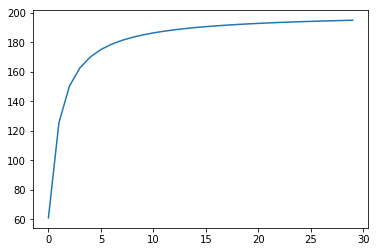

In [8]:
plt.plot(plot_data)
plt.show()

In [9]:
show_agent(wrap_env(gym.make(env_name)),theta_mean,theta_std)
display.stop()
show_video()

Final Reward:  200.0
